In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

from IPython.display import display

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-hk32p87v because the default path (/home/morshed/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
df = pd.read_csv('../session-3/Telco-Customer-Churn.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [3]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [4]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
       'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']

In [6]:
train_dicts = df_train[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [7]:
val_dicts = df_val[categorical + numerical].to_dict(orient='records')

X_val = dv.transform(val_dicts)

In [8]:
y_pred = model.predict_proba(X_val)[:, 1]

In [9]:
churn_decision = (y_pred > 0.5)
(y_val == churn_decision).mean()

0.8055358410220014

# 4.2 Accuracy and dummy model

In [10]:
len(y_val)

1409

In [11]:
(y_val == churn_decision).sum()

1135

In [12]:
1135/1409

0.8055358410220014

In [13]:
from sklearn.metrics import accuracy_score

thresholds = np.linspace(0, 1, 21)
scores = []
for t in thresholds:
    score = accuracy_score(y_val, y_pred > t)
    print('%.2f %.3f' % (t, score))
    scores.append(score) 

0.00 0.274
0.05 0.508
0.10 0.605
0.15 0.664
0.20 0.705
0.25 0.738
0.30 0.759
0.35 0.767
0.40 0.781
0.45 0.793
0.50 0.806
0.55 0.804
0.60 0.800
0.65 0.787
0.70 0.766
0.75 0.742
0.80 0.729
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


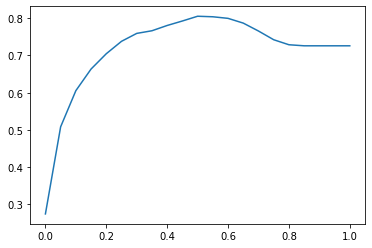

In [14]:
plt.plot(thresholds, scores)

In [15]:
from collections import Counter

In [16]:
Counter(y_pred >= 1.0)

Counter({False: 1409})

In [17]:
Counter(y_val)

Counter({0: 1023, 1: 386})

In [18]:
1-y_val.mean()

0.7260468417317246

# 4.3 Confusion table
* Different types of errors and correct decisions
* Arranging them in a table

In [19]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

t = 0.5
pred_positive = (y_pred >= t)
pred_negative = (y_pred < t)

In [20]:
pred_positive[:10]

array([False, False, False,  True, False, False, False, False,  True,
       False])

In [21]:
pred_negative

array([ True,  True,  True, ...,  True, False, False])

In [22]:
(actual_positive[:10] & pred_positive[:10]).sum()

2

In [23]:
(actual_positive & pred_positive)[:10]

array([False, False, False,  True, False, False, False, False,  True,
       False])

In [24]:
tp = (pred_positive & actual_positive).sum()
tn = (pred_negative & actual_negative).sum()

fp = (pred_positive & actual_negative).sum()
fn = (pred_negative & actual_positive).sum()

tp, tn

(212, 923)

In [25]:
fp = (pred_positive & actual_negative).sum()
fn = (pred_negative & actual_positive).sum()

fp, fn

(100, 174)

In [26]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])

confusion_matrix

array([[923, 100],
       [174, 212]])

In [27]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.66, 0.07],
       [0.12, 0.15]])

# 4.4 Precision and recall

### Precision
* how many positive prediction are correct
 * Freaction positive predictions thak are correct

### Recall
* Fraction of correctly identified positive examples


In [28]:
(tp + tn) / (tp + tn + fp + fn)

0.8055358410220014

** Precision
p = tp / (tp + fp)

In [29]:
p = tp / (tp + fp)
p

0.6794871794871795

In [30]:
tp + fp

312

In [31]:
tp

212

** Recall
r = tp / (tp + fn)

In [32]:
r = tp / (tp + fn)
r

0.5492227979274611

In [33]:
tp + fn

386

In [34]:
tp

212

# 4.5 ROC(Receiver Operating characteristic) Curves

### TRP and FRP

FPR = fp / (tn + fp)
TPR = tp / (tp + fn)

In [35]:
fpr = fp / (tn + fp)
tpr = tp / (tp + fn)

In [36]:
tpr, fpr

(0.5492227979274611, 0.09775171065493646)

In [37]:
r

0.5492227979274611

In [38]:
thresholds = np.linspace(0, 1, 101)
scores = []
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negetive = (y_val == 0)
    
    pred_positive = (y_pred >= t)
    pred_negative = (y_pred < t)
    
    tp = (pred_positive & actual_positive).sum()
    tn = (pred_negative & actual_negative).sum()

    fp = (pred_positive & actual_negative).sum()
    fn = (pred_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [39]:
scores

[(0.0, 386, 1023, 0, 0),
 (0.01, 385, 901, 1, 122),
 (0.02, 383, 808, 3, 215),
 (0.03, 382, 753, 4, 270),
 (0.04, 382, 714, 4, 309),
 (0.05, 379, 686, 7, 337),
 (0.06, 377, 656, 9, 367),
 (0.07, 375, 629, 11, 394),
 (0.08, 370, 596, 16, 427),
 (0.09, 370, 566, 16, 457),
 (0.1, 367, 537, 19, 486),
 (0.11, 364, 518, 22, 505),
 (0.12, 363, 496, 23, 527),
 (0.13, 361, 486, 25, 537),
 (0.14, 358, 461, 28, 562),
 (0.15, 353, 441, 33, 582),
 (0.16, 349, 429, 37, 594),
 (0.17, 347, 411, 39, 612),
 (0.18, 347, 398, 39, 625),
 (0.19, 342, 380, 44, 643),
 (0.2, 337, 367, 49, 656),
 (0.21, 332, 351, 54, 672),
 (0.22, 328, 337, 58, 686),
 (0.23, 322, 316, 64, 707),
 (0.24, 319, 307, 67, 716),
 (0.25, 314, 297, 72, 726),
 (0.26, 312, 287, 74, 736),
 (0.27, 310, 274, 76, 749),
 (0.28, 302, 261, 84, 762),
 (0.29, 299, 257, 87, 766),
 (0.3, 292, 245, 94, 778),
 (0.31, 289, 237, 97, 786),
 (0.32, 282, 235, 104, 788),
 (0.33, 279, 229, 107, 794),
 (0.34, 273, 220, 113, 803),
 (0.35000000000000003, 271, 2

In [40]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores[::10]

threshold   tp    fp   fn    tn
0          0.0  386  1023    0     0
10         0.1  367   537   19   486
20         0.2  337   367   49   656
30         0.3  292   245   94   778
40         0.4  252   175  134   848
50         0.5  212   100  174   923
60         0.6  155    51  231   972
70         0.7   69    13  317  1010
80         0.8    4     0  382  1023
90         0.9    0     0  386  1023
100        1.0    0     0  386  1023

In [41]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [42]:
df_scores[::10]

threshold   tp    fp   fn    tn       tpr       fpr
0          0.0  386  1023    0     0  1.000000  1.000000
10         0.1  367   537   19   486  0.950777  0.524927
20         0.2  337   367   49   656  0.873057  0.358749
30         0.3  292   245   94   778  0.756477  0.239492
40         0.4  252   175  134   848  0.652850  0.171065
50         0.5  212   100  174   923  0.549223  0.097752
60         0.6  155    51  231   972  0.401554  0.049853
70         0.7   69    13  317  1010  0.178756  0.012708
80         0.8    4     0  382  1023  0.010363  0.000000
90         0.9    0     0  386  1023  0.000000  0.000000
100        1.0    0     0  386  1023  0.000000  0.000000

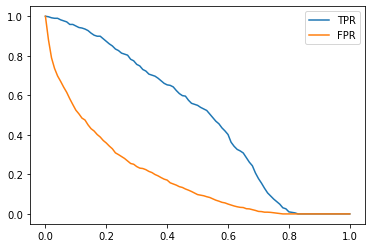

In [43]:
plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')
plt.legend()

### Random model

In [44]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val)).round(3)
y_rand

array([0.417, 0.72 , 0.   , ..., 0.774, 0.334, 0.089])

In [45]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [46]:
def tpr_fpr_datafram(y_val, y_pred):
    
    thresholds = np.linspace(0, 1, 101)
    scores = []
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negetive = (y_val == 0)

        pred_positive = (y_pred >= t)
        pred_negative = (y_pred < t)

        tp = (pred_positive & actual_positive).sum()
        tn = (pred_negative & actual_negative).sum()

        fp = (pred_positive & actual_negative).sum()
        fn = (pred_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))
    
    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores
    

In [47]:
df_rand = tpr_fpr_datafram(y_val, y_rand)
df_rand[::10]

threshold   tp    fp   fn    tn       tpr       fpr
0          0.0  386  1023    0     0  1.000000  1.000000
10         0.1  347   923   39   100  0.898964  0.902248
20         0.2  307   822   79   201  0.795337  0.803519
30         0.3  276   724  110   299  0.715026  0.707722
40         0.4  237   624  149   399  0.613990  0.609971
50         0.5  203   519  183   504  0.525907  0.507331
60         0.6  162   410  224   613  0.419689  0.400782
70         0.7  120   302  266   721  0.310881  0.295210
80         0.8   79   207  307   816  0.204663  0.202346
90         0.9   40   101  346   922  0.103627  0.098729
100        1.0    0     0  386  1023  0.000000  0.000000

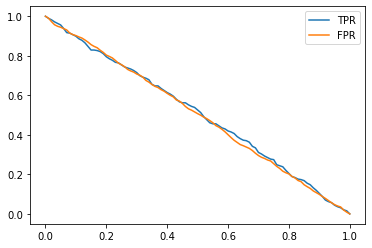

In [48]:
plt.plot(df_rand.threshold, df_rand.tpr, label='TPR')
plt.plot(df_rand.threshold, df_rand.fpr, label='FPR')
plt.legend()

### Ideal Model

In [49]:
num_neg = (y_val == 0).sum()
num_pog = (y_val == 1).sum()

num_neg, num_pog

(1023, 386)

In [50]:
np.random.seed(1)
y_ideal = np.repeat([0, 1], [num_neg, num_pog])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [51]:
(y_ideal == 1).sum()

386

In [52]:
y_ideal_pred = np.linspace(0, 1, len(y_val))
len(y_ideal_pred)

1409

In [53]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

In [54]:
1 - y_val.mean()

0.7260468417317246

In [55]:
df_ideal = tpr_fpr_datafram(y_ideal, y_ideal_pred)
df_ideal[::10]

threshold   tp    fp   fn    tn       tpr       fpr
0          0.0  386  1023    0     0  1.000000  1.000000
10         0.1  386   920    0   103  1.000000  0.899316
20         0.2  386   821    0   202  1.000000  0.802542
30         0.3  386   718    0   305  1.000000  0.701857
40         0.4  386   612    0   411  1.000000  0.598240
50         0.5  386   515    0   508  1.000000  0.503421
60         0.6  386   412    0   611  1.000000  0.402737
70         0.7  386   308    0   715  1.000000  0.301075
80         0.8  282   209  104   814  0.730570  0.204301
90         0.9  141   101  245   922  0.365285  0.098729
100        1.0    1     0  385  1023  0.002591  0.000000

In [56]:
plt.plot(df_ideal.threshold, df_ideal.tpr, label='TPR')
plt.plot(df_ideal.threshold, df_ideal.fpr, label='FPR')
plt.legend()

### puting everything together

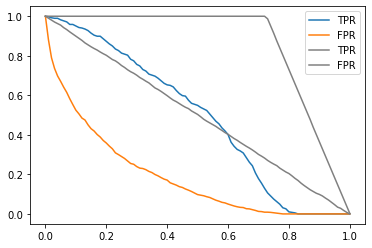

In [57]:
plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')

# plt.plot(df_rand.threshold, df_rand.tpr, label='TPR')
# plt.plot(df_rand.threshold, df_rand.fpr, label='FPR')

plt.plot(df_ideal.threshold, df_ideal.tpr, label='TPR', color='gray')
plt.plot(df_ideal.threshold, df_ideal.fpr, label='FPR', color='gray')

plt.legend()

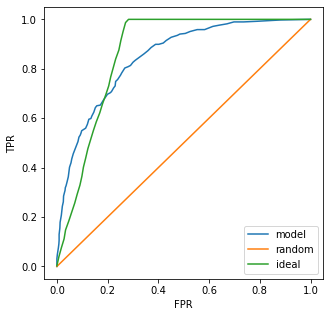

In [58]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot([0, 1], [0, 1], label='random')

# plt.plot(df_rand.fpr, df_rand.tpr, label='random')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [59]:
from sklearn.metrics import roc_curve

In [60]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
fpr, tpr, thresholds

(array([0.        , 0.        , 0.        , 0.00195503, 0.00195503,
        0.00391007, 0.00391007, 0.00488759, 0.00488759, 0.0058651 ,
        0.0058651 , 0.00684262, 0.00684262, 0.00782014, 0.00782014,
        0.00879765, 0.00879765, 0.01075269, 0.01075269, 0.01173021,
        0.01173021, 0.01270772, 0.01270772, 0.01368524, 0.01368524,
        0.01564027, 0.01564027, 0.01759531, 0.01759531, 0.01857283,
        0.01857283, 0.01955034, 0.01955034, 0.02052786, 0.02052786,
        0.02248289, 0.02248289, 0.02346041, 0.02346041, 0.02443793,
        0.02443793, 0.02541544, 0.02541544, 0.02639296, 0.02639296,
        0.02737048, 0.02737048, 0.02932551, 0.02932551, 0.03030303,
        0.03030303, 0.03128055, 0.03128055, 0.03225806, 0.03225806,
        0.03323558, 0.03323558, 0.0342131 , 0.0342131 , 0.03616813,
        0.03616813, 0.03714565, 0.03714565, 0.03910068, 0.03910068,
        0.0400782 , 0.0400782 , 0.04105572, 0.04105572, 0.04496579,
        0.04496579, 0.0459433 , 0.0459433 , 0.04

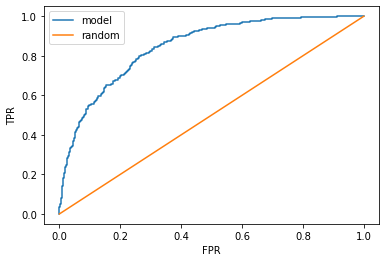

In [61]:
plt.plot(fpr, tpr, label='model')
plt.plot([0, 1], [0, 1], label='random')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

# 4.6 ROC AUC
* Area under the ROC curve - useful metric
* Interpretation of AUC

In [62]:
from sklearn.metrics import auc

In [63]:
auc(fpr, tpr)

0.8466032546761277

In [64]:
auc(df_scores.fpr, df_scores.tpr)

0.8463208889834327

In [65]:
auc(df_ideal.fpr, df_ideal.tpr)

0.8645189147027691

In [66]:
from sklearn.metrics import roc_auc_score

In [67]:
roc_auc_score(y_val, y_pred)

0.8466032546761277

In [68]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]
neg, pos

(array([0.00735889, 0.20971757, 0.22070437, ..., 0.08997092, 0.29530185,
        0.14887918]),
 array([0.57503581, 0.60349286, 0.46444821, 0.73354645, 0.07975757,
        0.69627211, 0.23665321, 0.68790916, 0.22061026, 0.66612532,
        0.43055266, 0.34817804, 0.162221  , 0.59340479, 0.75121243,
        0.15704443, 0.42233882, 0.28406832, 0.07690553, 0.21997222,
        0.64939313, 0.41436845, 0.66868993, 0.56273664, 0.54485431,
        0.43803499, 0.48618956, 0.33246906, 0.57785347, 0.33961198,
        0.6098827 , 0.7373689 , 0.72886121, 0.5896802 , 0.68023392,
        0.75762468, 0.10538758, 0.19263187, 0.51465323, 0.56795135,
        0.46474711, 0.48055818, 0.74937775, 0.38439908, 0.68500775,
        0.41904293, 0.74411565, 0.30039813, 0.52821658, 0.57391154,
        0.12336868, 0.5429425 , 0.77864891, 0.46029762, 0.67463039,
        0.76475214, 0.01415036, 0.37026688, 0.77062666, 0.57042262,
        0.68218439, 0.25787099, 0.36418707, 0.69762016, 0.21222909,
        0.6926246 , 0

In [69]:
import random

In [70]:
n = 1000
success = 0
for i in range(n):
    pos_ind = random.randint(0, len(pos) -1)
    neg_ind = random.randint(0, len(pos) -1)
    if pos[pos_ind] > neg[neg_ind]:
        success += 1

success / n

0.88

In [71]:
n = 1000
np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

In [72]:
(pos[pos_ind] > neg[neg_ind]).sum()

841

# 4.7 Cross Validation
* Evaluating the same model on different subsets of data
* Getting the average prediction and the spread within predictions

In [73]:
def train(df_train, y_train, C=1):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X_train, y_train)
    return dv, model

In [74]:
dv, model = train(df_train, y_train)

In [75]:
def pred(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

In [76]:
y_pred = pred(df_val, dv, model)

In [77]:
from sklearn.model_selection import KFold

In [78]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [79]:
kfold

KFold(n_splits=10, random_state=1, shuffle=True)

In [80]:
from tqdm.auto import tqdm

In [81]:
n_splits = 5

for C in [0.001, 0.01, 0.1, 0.5, 1, 5, 10]:
    scores = []

    for train_ind, val_ind in tqdm(kfold.split(df_full_train), total=n_splits):
        df_train = df_full_train.iloc[train_ind]
        df_val = df_full_train.iloc[val_ind]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C)

        y_pred = pred(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    print('%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/5 [00:00<?, ?it/s]

0.001 0.826 +- 0.016


  0%|          | 0/5 [00:00<?, ?it/s]

0.01 0.840 +- 0.012


  0%|          | 0/5 [00:00<?, ?it/s]

0.1 0.842 +- 0.012


  0%|          | 0/5 [00:00<?, ?it/s]

0.5 0.842 +- 0.012


  0%|          | 0/5 [00:00<?, ?it/s]

1 0.842 +- 0.012


  0%|          | 0/5 [00:00<?, ?it/s]

5 0.842 +- 0.012


  0%|          | 0/5 [00:00<?, ?it/s]

10 0.842 +- 0.012


In [82]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = pred(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8579400803839363